In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Jonathan\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Jonathan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._c

#Try ADVI, OPVI, IAF, NF, HF, SVGD, ASVGD to show variational inference

In [3]:
np.random.seed(42)
pm.set_tt_rng(42)

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import theano.tensor as tt

X, y = load_iris(True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
Xt = theano.shared(X_train)
yt = theano.shared(y_train)

with pm.Model() as iris_model:

    # Coefficients for features
    β = pm.Normal('β', 0, sd=1e2, shape=(4, 3))
    # Transoform to unit interval
    a = pm.Flat('a', shape=(3,))
    p = tt.nnet.softmax(Xt.dot(β) + a)

    observed = pm.Categorical('obs', p=p, observed=yt)

In [7]:
#SVGD
with iris_model:

    # We'll use SVGD
    inference = pm.SVGD(n_particles=500, jitter=1)

    # Local reference to approximation
    approx = inference.approx

    # Here we need `more_replacements` to change train_set to test_set
    test_probs = approx.sample_node(p, more_replacements={Xt: X_test}, size=100)

    # For train set no more replacements needed
    train_probs = approx.sample_node(p)

In [8]:
test_ok = tt.eq(test_probs.argmax(-1), y_test)
train_ok = tt.eq(train_probs.argmax(-1), y_train)
test_accuracy = test_ok.mean(-1)
train_accuracy = train_ok.mean(-1)

In [9]:
eval_tracker = pm.callbacks.Tracker(
    test_accuracy=test_accuracy.eval,
    train_accuracy=train_accuracy.eval
)

In [11]:
inference.fit(400, obj_optimizer=pm.adamax(learning_rate=0.1), callbacks=[eval_tracker]);

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [1:45:29<00:00, 15.82s/it]


C:\Users\Jonathan\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


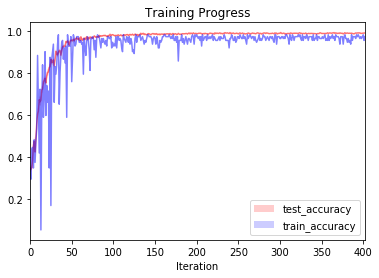

In [24]:
sns.tsplot(np.asarray(eval_tracker['test_accuracy']).T, color='red', alpha=.5)
sns.tsplot(np.asarray(eval_tracker['train_accuracy']).T, color='blue', alpha=.5)
plt.legend(['test_accuracy', 'train_accuracy'])
plt.xlabel("Iteration")
plt.title('Training Progress')
plt.savefig("svg_iris.png")

In [26]:
inference.approx.collect

<bound method Approximation.collect of <pymc3.variational.approximations.Empirical object at 0x0000024563009EF0>>